In [1]:
import torch
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams['savefig.bbox']='tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    plt.figure(figsize=(10,10))
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)   #Convert a tensor or an ndarray to PIL Image.
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

people1 = cv.imread(r'D:\image\5.jpg')
people2 = cv.imread(r'D:\image\6.jpg')
people1=people1.transpose(2,0,1)
people2=people2.transpose(2,0,1)
people1_float=torch.Tensor(people1)
people2_float=torch.Tensor(people2)
people1_uint8=people1_float.to(torch.uint8) 
people2_uint8=people2_float.to(torch.uint8)
grid = make_grid([people2_uint8, people2_uint8])
show(grid)       


AttributeError: 'NoneType' object has no attribute 'transpose'

### 测试pytorch的绘图工具

In [2]:
from torchvision.utils import draw_bounding_boxes
people1_int = cv.imread(r'D:\pytorch\pytorch_data\PennFudanPed\PNGImages\FudanPed00001.png')
boxes = torch.tensor([[50, 50, 100, 150], [110, 150, 200, 230]], dtype=torch.uint8 )
colors = ["blue", "yellow"]
#t=people1_int.to(torch.uint8) #转化为torch.uint8，否则下面画框失败
result = draw_bounding_boxes(people2_uint8, boxes, colors=colors,width=5)
show(result)

NameError: name 'people2_uint8' is not defined

In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

batch_int = torch.stack([people2_uint8])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(batch)
#print(outputs)

C:\Python39\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 720x720 with 0 Axes>

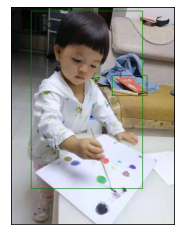

In [6]:
score_threshold = .9
person_with_boxes = [
    draw_bounding_boxes(people2_uint8, boxes=output['boxes'][output['scores'] > score_threshold], colors='green',width=4)
    for person_int, output in zip(batch_int, outputs)
]
show(person_with_boxes)

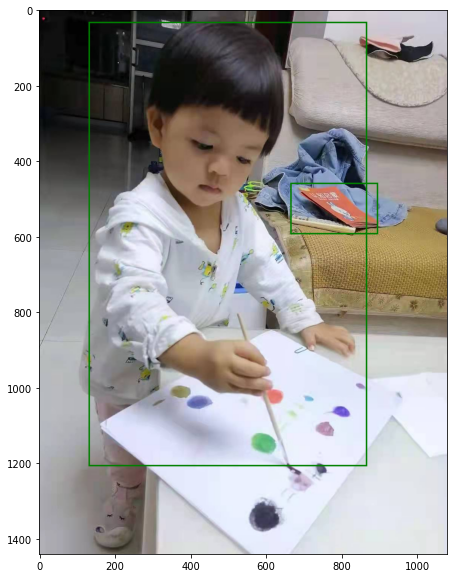

In [98]:
plt.figure(figsize=(10,10))
img=person_with_boxes[0].permute(1,2,0)
plt.imshow(np.array(img)[:,:,::-1])
plt.show()

In [7]:
from torchvision.models.segmentation import fcn_resnet50
model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()
normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 1440, 1080]) -5.304574012756348 12.826294898986816


<Figure size 720x720 with 0 Axes>

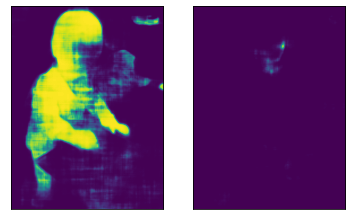

In [10]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'book', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1) #将图像按行缩放到0-1区间,每个维度之和为1
dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('person','book' )
]
show(dog_and_boat_masks)

shape = torch.Size([1, 1440, 1080]), dtype = torch.bool


<Figure size 720x720 with 0 Axes>

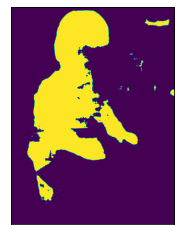

In [13]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['person'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

In [14]:
model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)

<Figure size 720x720 with 0 Axes>

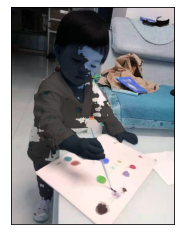

In [15]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(batch_int, boolean_dog_masks)
]
show(dogs_with_masks)

In [16]:
num_classes = normalized_masks.shape[1]
people_masks = normalized_masks[0]
class_dim = 0
people_all_classes_masks = people_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"people_masks shape = {people_masks.shape}, dtype = {people_masks.dtype}")
print(f"people_all_classes_masks = {people_all_classes_masks.shape}, dtype = {people_all_classes_masks.dtype}")

people_with_all_masks = draw_segmentation_masks(people1_uint8, masks=people_all_classes_masks, alpha=.6)
show(people_with_all_masks)

people_masks shape = torch.Size([21, 1440, 1080]), dtype = torch.float32
people_all_classes_masks = torch.Size([21, 1440, 1080]), dtype = torch.bool


ValueError: The image and the masks must have the same height and width

# fasterrcnn_resnet50_fpn 90个类别 ：

In [86]:

classes=[
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

